##  Importing Dependencies
   We shall start by importing all the neccessary libraries. I will explain the exact use of each library later in this notebook.

In [40]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 1.14.0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CZ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#  Dataset Preprocessing
In this notebook, we use news data scraped from DAWN and Business Recorder websites using Selenium package on python. The final CSV has news with their respected dates.

In [41]:
def load_data(filename):
    
    df = pd.read_csv(filename)
    df = df.dropna()
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by=['Date'])
    df = df.reset_index()
    df = df.drop(columns=['level_0','index'])
    return df
    
df = load_data('All_News.csv')
df.head()

,Date,News,Polarity,Sentiment,neg,neu,pos,compound,Cum
0,2011-01-04,Bone marrow recipients highlight consequences ...,0,0,0.248,0.560,0.192,-0.1779,0
1,2011-01-04,Zardari signs reference to reopen case of Bhut...,0,0,0.000,1.000,0.000,0.0000,0
2,2011-01-06,Grade 21 officer to head NDMA,0,0,0.000,1.000,0.000,0.0000,0
3,2011-01-06,'Pakistan risks becoming a polio transmission ...,0,0,0.296,0.704,0.000,-0.2732,0
4,2011-01-06,2009: US considers journalist’s request for in...,0,0,0.000,1.000,0.000,0.0000,0


The data was feature engineered and has different columns with the following interpretation:

- Polarity: The price change on the date news was published as positive (1), neutral (0) and negative (-1).
- Sentiment: Sentiment generated and engineered from Vader (NLTK Corpus) as good (1), neutral (0) and bad (-1)
- neg: The probability of news being negative (generated from Vader).
- neu: The probability of news being neutral (generated from Vader).
- pos: The probability of news being positive (generated from Vader).
- compound: The compound score of news being negative, neutral or positive scaled between -1 and 1 (generated from Vader).
- Cum: The cumulative score of the news engineered from Polarity and Sentiment.

In [42]:
df.describe()

,Polarity,Sentiment,neg,neu,pos,compound,Cum
count,10515.000000,10515.000000,10515.000000,10515.000000,10515.000000,10515.000000,10515.000000
mean,0.167000,0.167000,0.076030,0.830364,0.093605,0.087019,0.167000
std,0.799274,0.799274,0.124271,0.140714,0.109041,0.501812,0.799274
min,-1.000000,-1.000000,0.000000,0.099000,0.000000,-0.979900,-1.000000
25%,0.000000,0.000000,0.000000,0.750000,0.000000,-0.296000,0.000000
50%,0.000000,0.000000,0.000000,0.845000,0.071000,0.000000,0.000000
75%,1.000000,1.000000,0.128000,0.934000,0.161000,0.510600,1.000000
max,1.000000,1.000000,0.821000,1.000000,0.773000,0.973200,1.000000


Here, we can see and visualize the counts of all types of news in our data set.

In [43]:
df['Polarity'].value_counts()


 1    4383
 0    3505
-1    2627
Name: Polarity, dtype: int64

Positive: 4383 , Negative: 2627 , Neutral: 3505


Text(0.5, 1.0, 'Sentiment Data Distribution')

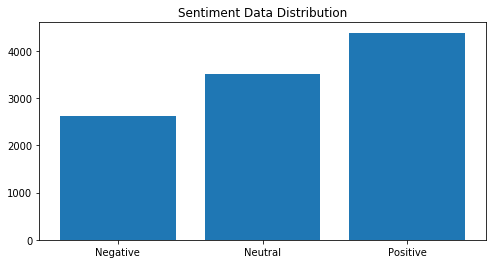

In [44]:
plt.figure(figsize=(8,4))
count_pos = df['Polarity'].value_counts()[1]
count_ntl = df['Polarity'].value_counts()[0]
count_neg = df['Polarity'].value_counts()[-1]

print('Positive:', count_pos, ',', 'Negative:', count_neg, ',', 'Neutral:', count_ntl)

plt.bar(['Negative', 'Neutral', 'Positive'], [count_neg, count_ntl, count_pos])
plt.title("Sentiment Data Distribution")

It's a very good dataset without any skewness. 

Now let us explore the data we hhave by checking a random sample.

In [45]:
import random
random_idx_list = [random.randint(1,len(df)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,Date,News,Polarity,Sentiment,neg,neu,pos,compound,Cum
9997,2020-11-02,NAB again summons Bilawal in fake accounts case,-1,-1,0.307,0.693,0.000,-0.4767,-1
6047,2019-01-14,NHS minister defends increase in drug prices,1,1,0.000,0.723,0.277,0.3182,1
4950,2018-01-24,Greek economy to grow 2.1pc this year: IOBE th...,1,1,0.000,0.924,0.076,0.3182,1
6045,2019-01-14,RECORDER REPORT: PSX close of day - KARACHI: ...,1,1,0.000,0.870,0.130,0.5574,1
2906,2015-11-11,LSE downs by 4.04 points - LAHORE: Lahore Stoc...,0,0,0.000,1.000,0.000,0.0000,0
2551,2015-04-13,LSE gains 13.46 points - LAHORE: Lahore Stock ...,1,1,0.000,0.802,0.198,0.6369,1
3120,2016-01-27,Passage of PIA bill in opposition absence not ...,-1,-1,0.153,0.847,0.000,-0.6202,-1
5133,2018-03-20,"RECORDER REPORT: PSX, BRIndex-30 update - KARA...",1,1,0.000,0.870,0.130,0.5574,1
528,2012-04-13,"Gold surges to Rs 49,371 - KARACHI: Gold surge...",0,0,0.000,0.925,0.075,0.2732,0
6898,2019-10-29,Need for encouraging young entrepreneurs stres...,1,1,0.055,0.622,0.323,0.8910,1


### Stemming/ Lematization
For grammatical reasons, documents are going to use different forms of a word, such as *write, writing and writes.* Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes. 

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word
![Stemming and Lematization](https://qph.fs.quoracdn.net/main-qimg-cd7f4bafaa42639deb999b1580bea69f)

### Hyperlinks and Mentions
News may have tags and hyperlinks in them which may not come in our use so it is important to remove them.

### Stopwords
Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. Some stopwords are...
![Stopwords English](https://4.bp.blogspot.com/-yiEr-jCVv38/Wmk10d84DYI/AAAAAAAAk0o/IfgjfjpgrxM5NosUQrGw7PtLvgr6DAG8ACLcBGAs/s1600/Screen%2BShot%2B2018-01-24%2Bat%2B5.41.21%2BPM.png)


**NLTK** is a python library which got functions to perform text processing task for NLP.



In [46]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [47]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [48]:
def preprocesser(df):
    df.text = df['News'].apply(lambda x: preprocess(x))
    return df

df = preprocesser(df)

C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [49]:
df.tail()

,Date,News,Polarity,Sentiment,neg,neu,pos,compound,Cum
10510,2021-12-01,Court postpones Gilani's indictment till Febru...,0,0,0.07,0.930,0.000,-0.2732,0
10511,2021-12-01,Commissioner inaugurates anti-polio campaign -...,0,0,0.00,1.000,0.000,0.0000,0
10512,2021-12-01,Anti-polio campaign in full swing - Hussain in...,0,0,0.00,1.000,0.000,0.0000,0
10513,2021-12-01,Procurement of COVID vaccine will take some ti...,0,0,0.00,0.972,0.028,0.0772,0
10514,2021-12-01,Former model Frieha Altaf is the latest target...,0,0,0.00,1.000,0.000,0.0000,0




### Positive Words

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 

temp = df.sort_values(by=['Polarity'], ascending = False)
print(temp[0:count_pos+4])
text = ' '.join(temp["News"][0:count_pos])


    
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(text)
plt.imshow(wc , interpolation = 'bilinear')

            Date                                               News  Polarity  \
2770  2015-08-26  Stock wobbles persist despite China rate cut -...         1   
3602  2016-07-03  Saudi investors keen in investment, joint vent...         1   
6966  2019-11-10  AkzoNobel introduces Dulux weathershield - Akz...         1   
6967  2019-11-10  Multimodal transport service via train initiat...         1   
3620  2016-07-11  Rice export orders to bring relief to farmers ...         1   
...          ...                                                ...       ...   
1958  2014-10-05  Home work completed to introduce Arabic langua...         1   
9956  2020-10-23  Civil awards: Senate body dismayed at lack of ...         0   
5600  2018-08-14  Junoon has a new video out for their old class...         0   
10389 2021-01-19  Faisal Javed terms PDM protest another attempt...         0   
10388 2021-01-19  Federal Cabinet constitutes inquiry committee ...         0   

       Sentiment    neg    

### Neutral Words

In [ ]:
plt.figure(figsize = (20,20)) 
temp = df.sort_values(by=['Polarity'], ascending = False)
print(temp[count_pos:count_pos + count_ntl])
text = ' '.join(temp["News"][count_pos:count_pos + count_ntl])


    
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(text)
plt.imshow(wc , interpolation = 'bilinear')

### Negative Words

In [ ]:
plt.figure(figsize = (20,20)) 
temp = df.sort_values(by=['Polarity'], ascending = False)
print(temp[count_pos + count_ntl:])
text = ' '.join(temp["News"][count_pos + count_ntl:])


    
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(text)
plt.imshow(wc , interpolation = 'bilinear')

## Train and Test Split

We split our data in 2 sets, train consisting of 70% data and test consisting of 30% data.

In [ ]:
TRAIN_SIZE = 0.3
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 100

def _train_test_split(df, TRAIN_SIZE):
    
    train_data, dump = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=7) # Splits Dataset into Training and Testing set
    test_data = df.iloc[int(len(df)*0.3):]
    
    return train_data, test_data

train_data, test_data = _train_test_split(df, TRAIN_SIZE)

In [ ]:
print(train_data.shape, test_data.shape)

`train_test_split` will shuffle the dataset and split it to gives training and testing dataset. It's important to shuffle our dataset before training.

In [ ]:
train_data.describe()


# Tokenization


In [ ]:
from keras.preprocessing.text import Tokenizer

def tokenize(train_data):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_data['News'])

    word_index = tokenizer.word_index
    vocab_size = len(tokenizer.word_index) + 1
    return tokenizer, word_index, vocab_size

tokenizer, word_index, vocab_size = tokenize(train_data)
    

In [ ]:
from keras.preprocessing.sequence import pad_sequences

def sequence_padder(train_data, MAX_SEQUENCE_LENGTH):

    x_train = pad_sequences(tokenizer.texts_to_sequences(train_data['News']),
                            maxlen = MAX_SEQUENCE_LENGTH)
    x_test = pad_sequences(tokenizer.texts_to_sequences(test_data['News']),
                           maxlen = MAX_SEQUENCE_LENGTH)
    
    return x_train, x_test

x_train, x_test = sequence_padder(train_data, MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

### Label Encoding 
We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.

In [ ]:
from keras.utils.np_utils import to_categorical

def encode_labels(train_data, test_data):
    
    train_labels = to_categorical(train_data['Polarity'], num_classes=3)
    test_labels = to_categorical(test_data['Polarity'], num_classes=3)
    #labels = np.argmax(labels, axis=1)
    y_train = train_labels
    y_test = test_labels
    return train_labels, test_labels, y_train, y_test

train_labels, test_labels, y_train, y_test = encode_labels(train_data, test_data)

# Word Emdedding


In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip


In [ ]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 10
MODEL_PATH = 'best_model.hdf5'

In [ ]:
embeddings_index = {}

f = open(GLOVE_EMB, encoding="utf8")
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

In [ ]:
def embedder(EMBEDDING_DIM, vocab_size):
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

    embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                              EMBEDDING_DIM,
                                              weights=[embedding_matrix],
                                              input_length=MAX_SEQUENCE_LENGTH,
                                              trainable=False)
    return embedding_layer

embedding_layer = embedder(EMBEDDING_DIM, vocab_size)

# Model Training - BiDirectional LSTM and Single layer CNN


In [ ]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential

In [ ]:
def create_model(MAX_SEQUENCE_LENGTH, embedding_layer):
    
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    #x = Sequential()
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5)(x)
    x = Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(3, activation='sigmoid')(x)
    print(outputs)
    model = tf.keras.Model(sequence_input, outputs)
    
    return model

model = create_model(MAX_SEQUENCE_LENGTH, embedding_layer)

plot_model(model)
print(model.summary())

The model has 1 embedding layer, 1 Convolutional 1D layer with 96,064 parameters, 1 BiDirectional LSTM layer with 24,832 parameters and 2 dense layers with 512 neurons, ReLU activation and 33,280 and 26,2656 parameters each. The final dense layer has 3 output dimensions (good, neutral, bad), Sigmoid activation with 1,539 parameters. There are several dropouts of 20% to ensure there is no overfitting. 

There are a total of 3,619,071 parameters of which 418,371 are trainable (LSTM and Dense).



### Callbacks


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

def compiler(model, LR):
    
    model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
                  metrics=['acc'])
    ReduceLROnPlateau_ = ReduceLROnPlateau(factor=0.1,
                                         min_lr = 0.01,
                                         monitor = 'val_loss',
                                         verbose = 1)
    
    return model, ReduceLROnPlateau_

model, ReduceLROnPlateau_ = compiler(model, LR)

In [ ]:
def fit_model(model, x_train, y_train, BATCH_SIZE, EPOCHS, x_test, y_test):

    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                        validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau_], verbose = 0)
    
    return history

history = fit_model(model, x_train, y_train, BATCH_SIZE, EPOCHS, x_test, y_test)
    

In [ ]:
import tensorflow.keras.models

model.save('temp.h5')
model = tf.keras.models.load_model('temp' + '.h5')


# Model Evaluation


In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['acc'], c= 'b')
at.plot(history.history['val_acc'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
def decode_sentiment(score):
    if score[0] > score[1] and score[0] > score[2]:
        #print(score[0], '0\n---')
        return 0
    elif score[1] > score[0] and score[1] > score[2]:
        #print(score[1], '1\n---')
        return 1
    elif score[2] > score[0] and score[2] > score[1]:
        #print(score[2], '-1\n---')
        return -1

def sentiment_decoder(model, x_test):
    
    scores = model.predict(x_test, verbose=0, batch_size=10)
    y_pred_1d = [decode_sentiment(score) for score in scores]
    
    return scores, y_pred_1d

scores, y_pred_1d = sentiment_decoder(model, x_test)
    

In [ ]:
len(y_pred_1d)

### Confusion Matrix
Confusion Matrix provide a nice overlook at the model's performance in classification task

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

In [ ]:
def cnf_plotter(test_data, y_pred_1d):

    cnf_matrix = confusion_matrix(test_data['Polarity'].to_list(), y_pred_1d)
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(cnf_matrix, classes=test_data['Polarity'].unique(), title="Confusion matrix")
    plt.show()

### Classification Scores

In [ ]:
print(classification_report(list(test_data['Polarity']), y_pred_1d))

### Run on 100 files

In [ ]:
KSE100 = pd.read_csv('KSE100.csv')

for i in range(76, len(KSE100)):
    
    print('Iteration:', i)
    name = KSE100['Ticker'][i]
    print(name)
    load_name = 'M2 cleaned files/' + name +'.csv'
    load_name_tech = 'Indicators/' + name +'.csv'
    
    df = load_data(load_name)
    df = preprocesser(df)
    
    train_data, test_data = _train_test_split(df, TRAIN_SIZE)
    tokenizer, word_index, vocab_size = tokenize(train_data)
    x_train, x_test = sequence_padder(train_data, MAX_SEQUENCE_LENGTH)
    train_label, test_labels, y_train, y_test = encode_labels(train_data, test_data)
    embedding_layer = embedder(EMBEDDING_DIM, vocab_size)
    
    model = create_model(MAX_SEQUENCE_LENGTH, embedding_layer)
    model, ReduceLROnPlateau_ = compiler(model, LR)
    history = fit_model(model, x_train, y_train, BATCH_SIZE, EPOCHS, x_test, y_test)
    
    model.save('M2 Saved Models/' + name + '.h5')
    model = tf.keras.models.load_model('M2 Saved Models/' + name + '.h5')
    
    scores, y_pred_1d = sentiment_decoder(model, x_test)
    
    cnf_plotter(test_data, y_pred_1d)
    print(classification_report(list(test_data['Polarity']), y_pred_1d))
    
    output = df.iloc[int(len(df)*TRAIN_SIZE):]
    output['Pred'] = y_pred_1d
    output = output.reset_index(drop=True)
    pred = pd.read_csv(load_name_tech)
    pred['Date'] = pd.to_datetime(pred['Date']) 
    start_date = output['Date'][0]
    end_date = pred['Date'][len(pred)-1]

    start = pred.index[pred['Date'] == start_date].to_list()[0]
    pred = pred.iloc[start:]
    end = output.index[output['Date'] == end_date].to_list()[0]
    output = output.iloc[:end]
    
    temp = output.groupby(['Date'], as_index = False).mean()

    pred['Score'] = [0 for i in range(len(pred))]

    for j in range(len(temp)):

        date = temp['Date'][j]

        index = pred.index[pred['Date'] == date]

        pred['Score'][index] = temp['Pred'][j]

    pred.to_csv(path_or_buf = 'M2 output/' + name + '.csv', index = False) #Save dataframe as CSV